In [73]:
import pprint
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from skimage.io import imshow
from sklearn import metrics as mt
from matplotlib import pyplot as plt

from sklearn import datasets, metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, InputLayer

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

keras.__version__

# You must download the data set from the following URL:
# https://www.cs.toronto.edu/~kriz/cifar.html

'2.12.0'

In [2]:
# tf.config.list_physical_devices('GPU')
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num of GPUs available:  13
Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



# Lab Assignment Six: Convolutional Network Architectures

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In this assignment, we will select a prediction task to perform on our dataset, evaluate a deep learning architecture and tune hyper-parameters.

**Dataset Selection**<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset must be image data. We will multi-class classification.

## Preparation

#### **[1.5 points]** Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dataset used is called cifar10 and it consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. Since the classes are evenly distributed among the dataset, we will use accuracy as the metric to evaluate the models' performances. The note above mentions that accuracy is rarely the best evaluation metric to use because it is a poor metric for datasets that have class imbalances, and that is how most of real world data is distributed.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For example, take a 2 class problem where there are 9,990 samples of Class 0, but only 10 samples of Class 1. If the model only predicts Class 0, it will have an accuracy of 99.9%. This number is misleading because it does not detect any Class 1 samples. In our case, the classes are balanced as mentioned previously, so accuracy is an appropriate measure for this dataset.<br/>

In [3]:
# Load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Print shapes of datasets
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print(f'Training Size: {X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100:.2f}%')
print(f'Testing Size: {X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100:.2f}%')

# Print unique classes
print('Unique classes: ',end='')
print(np.unique(y_train))

NUM_CLASSES = len(np.unique(y_train))

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Training Size: 83.33%
Testing Size: 16.67%
Unique classes: [0 1 2 3 4 5 6 7 8 9]


In [4]:
labels = {
    0: 'airplane',
    1:	'automobile',
    2:	'bird',
    3:	'cat',
    4:	'deer',
    5:	'dog',
    6:	'frog',
    7:	'horse',
    8:	'ship',
    9:	'truck'
}

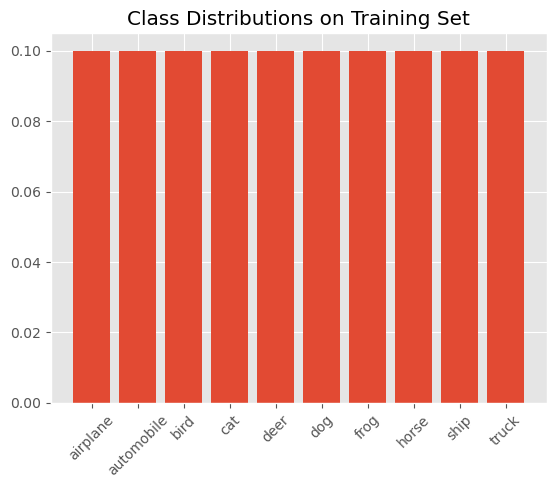

In [5]:
# Get the unique values and their counts
unique, counts = np.unique(y_train, return_counts=True)

# Calculate the proportions of each value
proportions = counts / len(y_train)

plt.bar(x=labels.values(), height=proportions)
plt.title('Class Distributions on Training Set')
plt.xticks(rotation=45)
plt.show()

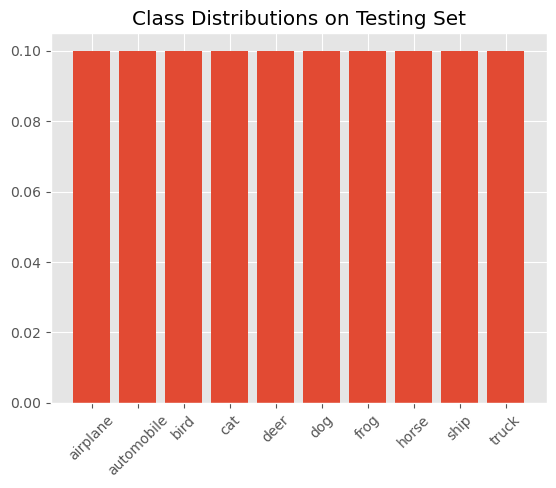

In [6]:
# Get the unique values and their counts
unique, counts = np.unique(y_test, return_counts=True)

# Calculate the proportions of each value
proportions = counts / len(y_test)

plt.bar(x=labels.values(), height=proportions)
plt.title('Class Distributions on Testing Set')
plt.xticks(rotation=45)
plt.show()

#### **[1.5 points]** Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As mentioned in the previous section, cifar10 is already split into training and testing datasets with equal class distribution. Therefore, we will be using the given training and testing datasets as they solve the class imbalance problem and have a good distribution of the data, 84-17. Generally, the acceptable split is 80-20. The current split is advantageous to our accuracy metric.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We opted to not do k-fold cross-validation as we have a large dataset and the models will take too long to train and test. The random split we have is sufficiently good for our purposes and time constraints.

## Modeling

#### **[1.5 points]**  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/.)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Data expansion is a technique used for training machine learning models so that they can recognize images in different angles and rotations. It works by creating new images by applying a transformation, like flipping, rotating, scaling, or cropping, to the existing images in the dataset. Its main goal is to enhance the performance of the model by preventing overfitting. Furthermore, the technique must account for the missing pixels. By applying the transformation, the image might not fit exactly into its original shape. For example, rotate a squared image by 45 degrees. The image would have the shape of a diamond, and, therefore, would have empty spaces in the square frame). The data expansion technique must specify a way to fill those gaps. Some common ways to do it are nearest neighbor interpolation and linear interpolation.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before choosing how we will expand our data, let's take a look at how some of the pictures look like.

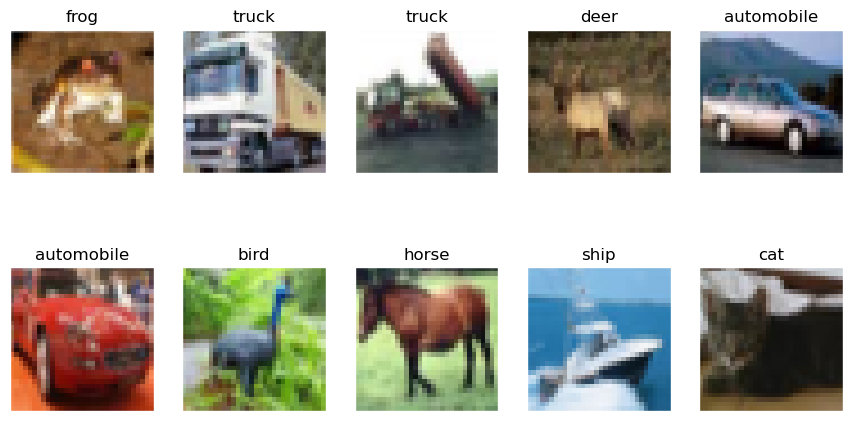

In [7]:
# Helper function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6,alt_labels=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze())
        plt.title(alt_labels[titles[i][0]], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 32, 32,alt_labels=labels,n_col=5,n_row=2)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Given the nature of our classes and domain knowledge, we will add some variations to our images, but nothing too crazy. We will flip them and rotate them slightly, but we will not be changing their color schemes or flipping them upside down as there is no need for such operations. Below are some examples of how the augmented pictures will look like. Unfortunately, due to the low quality, it is quite hard to see details of each transformation, but the rotations are still very clear in the images.

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

# fits the model on batches with real-time data augmentation:
datagen.fit(X_train)

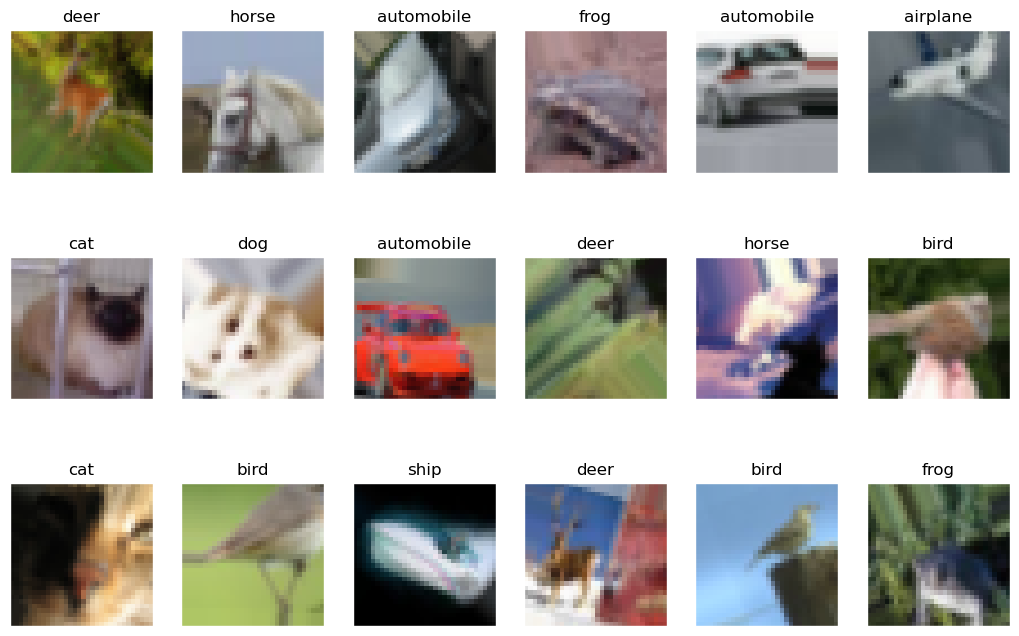

In [9]:
# Plot generated images
tmp_x = datagen.flow(X_train,y_train,batch_size=64,subset='training')


gen_data = tmp_x.next()

generated_labels = gen_data[1]
generated_imgs = gen_data[0]

generated_labels = np.array(generated_labels)


plot_gallery(generated_imgs/255.0,generated_labels,h=32,w=32,alt_labels=labels)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before feeding the data to our models, we need to make sure that the data is scaled correctly. Each sample is has a dimension of 32x32x3. That means that each image is 32x32 pixels. Each datapoint represents a single pixel, and its value is stored by its RGB values. That is why all values are between 0-255. However, it is preferable for machine learning algorithms to work with normalized values. Thus, all values have been scaled to the range 0.0-1.0, inclusive.

In [10]:
print(f'Max Before Scale: {np.max(X_train.max())}')
print(f'Max Before Scale: {np.min(X_train.min())}')
print(f'Shape before Scale: {X_train.shape}')

X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

print(f'Max After Scale: {np.max(X_train.max())}')
print(f'Max Before Scale: {np.min(X_train.min())}')
print(f'Shape after Scale: {X_train.shape}')

Max Before Scale: 255
Max Before Scale: 0
Shape before Scale: (50000, 32, 32, 3)
Max After Scale: 1.0
Max Before Scale: 0.0
Shape after Scale: (50000, 32, 32, 3)


#### **[2 points]** Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

##### **Creating Models**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have created 2 different convolutional network architectures. We also changed the number of filters and the stride values on both models at each convolution layer so that we have different variations to test the hyperparameter values.

In [11]:
def modelA_1_gen():
    cnn4 = Sequential()
    cnn4.add(Conv2D(50,(3,3), strides=1, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2), strides=2,padding='same'))

    cnn4.add(Conv2D(25,(3,3), strides=1, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(Dropout(0.2))
    cnn4.add(BatchNormalization())

    cnn4.add(MaxPooling2D((2,2),strides=1,padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2),strides=2,padding='same'))

    cnn4.add(Flatten())
    cnn4.add(Dense(units=512,activation='relu'))
    cnn4.add(Dense(units=NUM_CLASSES))
    cnn4.add(Activation('softmax'))
    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return cnn4

In [12]:
def modelA_2_gen():
    cnn4 = Sequential()
    cnn4.add(Conv2D(75,(3,3), strides=2, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2), strides=2,padding='same'))

    cnn4.add(Conv2D(50,(3,3), strides=2, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(Dropout(0.2))
    cnn4.add(BatchNormalization())

    cnn4.add(MaxPooling2D((2,2),strides=1,padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2),strides=2,padding='same'))

    cnn4.add(Flatten())
    cnn4.add(Dense(units=512,activation='relu'))
    cnn4.add(Dense(units=NUM_CLASSES))
    cnn4.add(Activation('softmax'))
    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return cnn4

In [13]:
def modelB_1_gen():
    mod = Sequential()
    mod.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=1, padding='same'))

    mod.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=2, padding='same'))

    mod.add(Conv2D(256, (3,3), strides=2, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    
    mod.add(Flatten())
    mod.add(Dense(units=512,activation='relu'))
    mod.add(Dense(units=NUM_CLASSES))
    mod.add(Activation('softmax'))
    mod.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return mod

In [14]:
def modelB_2_gen():
    mod = Sequential()
    mod.add(Conv2D(128, (3,3), strides=2, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=2, padding='same'))

    mod.add(Conv2D(256, (3,3), strides=2, padding='same', activation='relu'))
    mod.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    mod.add(MaxPooling2D((3,3), strides=2, padding='same'))

    mod.add(Conv2D(512, (3,3), strides=4, padding='same', activation='relu'))
    mod.add(Activation('relu'))
    mod.add(BatchNormalization())
    
    mod.add(Flatten())
    mod.add(Dense(units=512,activation='relu'))
    mod.add(Dense(units=NUM_CLASSES))
    mod.add(Activation('softmax'))
    mod.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return mod

##### Training and Testing

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;With the architectures and their variations constructed, we are ready to start training and fitting the data. We will train the data on the training set with augmented images. Then we will test each model's performance on the testing data set.

In [15]:
# One hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [16]:
# FIXME - lowered values to test
args = {'epochs': 2, 'shuffle': True, 'verbose': 1, 'steps_per_epoch': int(len(X_train)/128)}

In [17]:
# Helper Functions

# Trains the model on the training test with image generator
# Returns History
def fit_gen(model, X_train, y_train_ohe, X_test, y_test_ohe, name='Model', **args):
    # Fit the data and get the history from Keras
    history = model.fit_generator(datagen.flow(X_train, y_train_ohe), 
                  **args,
                  validation_data=(X_test,y_test_ohe)
                )
    plot_model(
        model, to_file=f'{name}.png', show_shapes=True, show_layer_names=True,
        rankdir='LR', expand_nested=False, dpi=96
    )
    return history

# Plots History of a model
def plot_hist(history, title="Model Accuracy"):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Plot the training and validation loss values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [18]:
%%time
modelA_1 = modelA_1_gen()
hist_A_1 = fit_gen(modelA_1, X_train, y_train_ohe, X_test, y_test_ohe, 'Model A_1', **args)

Epoch 1/2


2023-04-29 13:11:01.685673: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


390/390 [==============================] - 17s 41ms/step - loss: 1.8767 - accuracy: 0.3413 - val_loss: 4.4977 - val_accuracy: 0.1624
Epoch 2/2
390/390 [==============================] - 18s 46ms/step - loss: 1.6341 - accuracy: 0.4105 - val_loss: 1.8862 - val_accuracy: 0.3493
CPU times: user 44.9 s, sys: 11.5 s, total: 56.4 s
Wall time: 36.3 s


In [20]:
%%time
modelA_2 = modelA_2_gen()
hist_A_2 = fit_gen(modelA_2, X_train, y_train_ohe, X_test, y_test_ohe, 'Model A_2', **args)

Epoch 1/2
390/390 [==============================] - 18s 43ms/step - loss: 1.8928 - accuracy: 0.3149 - val_loss: 2.8668 - val_accuracy: 0.1555
Epoch 2/2
390/390 [==============================] - 16s 40ms/step - loss: 1.6894 - accuracy: 0.3867 - val_loss: 1.6823 - val_accuracy: 0.3797
CPU times: user 42.6 s, sys: 10.7 s, total: 53.3 s
Wall time: 34.4 s


In [21]:
%%time
modelB_1 = modelB_1_gen()
hist_B_1 = fit_gen(modelB_1, X_train, y_train_ohe, X_test, y_test_ohe, 'Model B_1', **args)

Epoch 1/2
390/390 [==============================] - 65s 162ms/step - loss: 1.9920 - accuracy: 0.3164 - val_loss: 2.4177 - val_accuracy: 0.2816
Epoch 2/2
390/390 [==============================] - 62s 158ms/step - loss: 1.6529 - accuracy: 0.3976 - val_loss: 1.5378 - val_accuracy: 0.4364
CPU times: user 1min 12s, sys: 19.4 s, total: 1min 31s
Wall time: 2min 7s


In [22]:
%%time
modelB_2 = modelB_2_gen()
hist_B_2 = fit_gen(modelB_2, X_train, y_train_ohe, X_test, y_test_ohe, 'Model B_2', **args)

Epoch 1/2
390/390 [==============================] - 28s 67ms/step - loss: 2.0090 - accuracy: 0.2920 - val_loss: 3.1443 - val_accuracy: 0.1730
Epoch 2/2
390/390 [==============================] - 30s 78ms/step - loss: 1.7124 - accuracy: 0.3750 - val_loss: 1.6514 - val_accuracy: 0.4142
CPU times: user 1min 8s, sys: 15.8 s, total: 1min 24s
Wall time: 59.2 s


#### **[1.5 points]** Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have determined to do 50 epochs so that the models can train enough to have reliable accuracies. Their performances of the training and validation sets per iteration are plotted in the graphs below.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FIXME: Run enough epochs to have nice graphs and analyze them.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FIXME: Add some statistics.

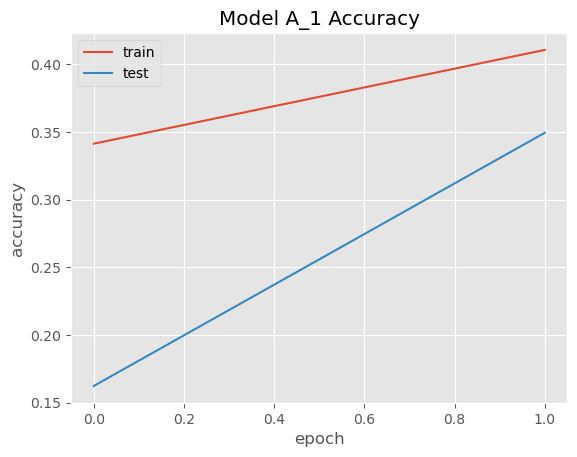

In [23]:
plot_hist(hist_A_1, 'Model A_1 Accuracy')

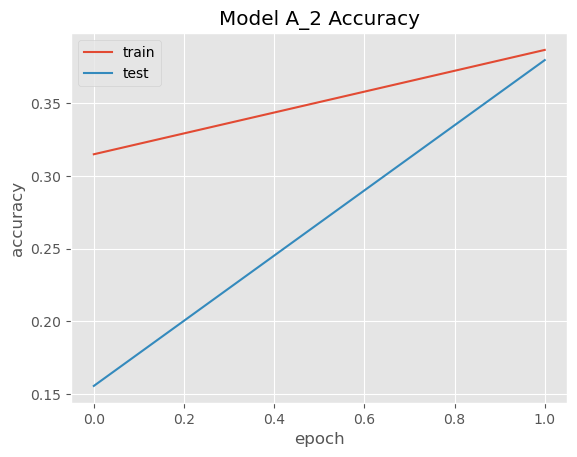

In [24]:
plot_hist(hist_A_2, 'Model A_2 Accuracy')

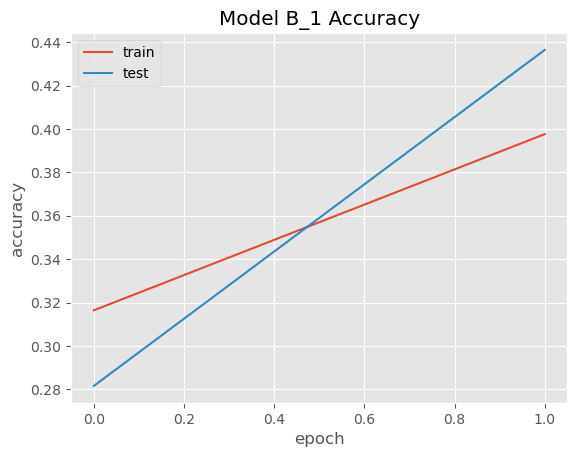

In [25]:
plot_hist(hist_B_1, 'Model B_1 Accuracy')

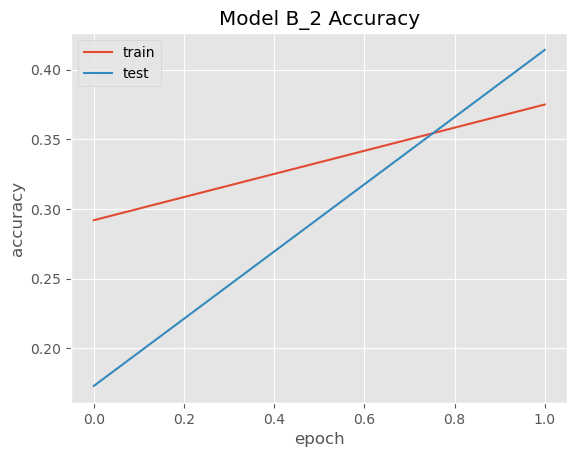

In [26]:
plot_hist(hist_B_2, 'Model B_2 Accuracy')

#### **[1 points]** Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will compare the performance of our best model, [FIXME: BLANK], against a standard Multi-Layer Perceptron (MLP).

In [28]:
%%time
# Create MLP
def MLP_gen():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(64, activation='relu', input_dim=100))
    model.add(Dense(10, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

MLP = MLP_gen()

# Train MLP
hist_MLP = fit_gen(MLP, X_train, y_train_ohe, X_test, y_test_ohe, 'MLP', **args)

Epoch 1/2
390/390 [==============================] - 6s 14ms/step - loss: 0.3334 - accuracy: 0.1843 - val_loss: 0.3092 - val_accuracy: 0.2617
Epoch 2/2
390/390 [==============================] - 7s 18ms/step - loss: 0.3148 - accuracy: 0.2241 - val_loss: 0.3017 - val_accuracy: 0.2572
CPU times: user 20.5 s, sys: 4.6 s, total: 25.1 s
Wall time: 13.7 s


In [75]:
# Get predictions
y_hat_mlp = MLP.predict(X_test)
# FIXME: Pick actual best model
y_hat_best = modelA_1.predict(X_test)

313/313 [==============================] - 1s 5ms/step


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To compare our best model to the MLP, we will plot their Receiver Operating Characteristic (ROC) and along with their Area Under the Curve (AUC) score.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ROC curves plot the true positive rate (TPR) on the Y axis, and false positive rate (FPR) on the X axis. This means that the top left corner is the ideal spot, and we want our curves as close to that corner as possible. The AUC score is calculated as literally the area under the ROC curve - we want it to be as large as possible.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ROC curves are usually plotted for binary classification problems. However, we can solve this problem by implementing a One-vs-All ROC curve, which is what we will be doing. It consists in computing a ROC curve per each of the classes, where in each step, the current class is considered positive and all others are seen as negative. Another strategy is doing a One-vs-One ROC, but its complexity is O(n_classes ^2).

In [93]:
# Calculates ROC curve and AUC score using the OvR macro-average
def roc_OvR_cal(y_onehot_test=y_test_ohe, y_score=None):
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= NUM_CLASSES

    return fpr_grid, mean_tpr, auc(fpr_grid, mean_tpr)

# Get values for ROC Curve and AUC Scores
fpr_mlp, tpr_mlp, auc_mlp = roc_OvR_cal(y_test_ohe, y_hat_mlp)
fpr_best, tpr_best, auc_best = roc_OvR_cal(y_test_ohe, y_hat_best)

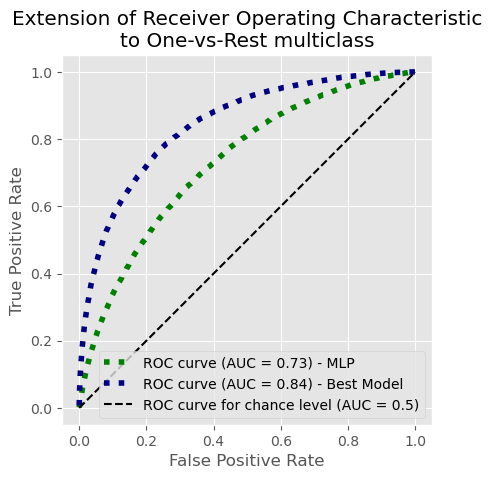

In [94]:
# Plot ROC Curves with AUC Scores
plt.plot(
    fpr_mlp, tpr_mlp,
    label=f"ROC curve (AUC = {auc_mlp:.2f}) - MLP",
    color="green",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr_best, tpr_best,
    label=f"ROC curve (AUC = {auc_best:.2f}) - Best Model",
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

FIXME: Analyze graph

## Exceptional Work

#### One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 